# Objectives & Universal Soldier Analysis 🚩

**Analyzing Objective-Based Gameplay and Multi-Category Performance**

This notebook explores the 'Objectives' dataset (Wools, Cores, Monuments) and identifies 'Universal Soldiers'—players who excel across all three dimensions: Combat (PvP), Activity (Matches), and Strategy (Objectives).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Setup
plt.style.use('default')
sns.set_palette('viridis')
%matplotlib inline

# Paths
DATA_DIR = Path('../data/processed')
PLOTS_DIR = Path('../plots')
PLOTS_DIR.mkdir(exist_ok=True)

print("✓ Setup complete!")

✓ Setup complete!


## 1. Load the Golden Dataset 🏆
We use the intersection dataset containing players present in **all 3 leaderboards**.

In [2]:
df = pd.read_parquet(DATA_DIR / 'golden_dataset.parquet')
print(f"Loaded Golden Dataset: {len(df):,} players")
print(f"Total Features: {len(df.columns)}")

Loaded Golden Dataset: 3,490 players
Total Features: 55


## 2. Descriptive Stats: Objectives 🎯
Let's look at the distribution of objective-based stats.

In [3]:
obj_cols = ['wools_objectives', 'wools_touched_objectives', 
            'cores_objectives', 'monuments_objectives']

# Summary stats
print("OBJECTIVE STATS SUMMARY")
print("="*60)
print(df[obj_cols].describe().round(2))

OBJECTIVE STATS SUMMARY
       wools_objectives  wools_touched_objectives  cores_objectives  \
count           3490.00                   3490.00           3490.00   
mean              56.94                    199.80             11.42   
std              160.05                    478.24             35.32   
min                2.00                      0.00              0.00   
25%                5.00                     26.00              1.00   
50%               13.00                     56.00              2.00   
75%               40.00                    155.00              8.00   
max             3005.00                   7260.00            754.00   

       monuments_objectives  
count               3490.00  
mean                  46.53  
std                  126.01  
min                    0.00  
25%                    5.00  
50%                   12.00  
75%                   35.00  
max                 2563.00  


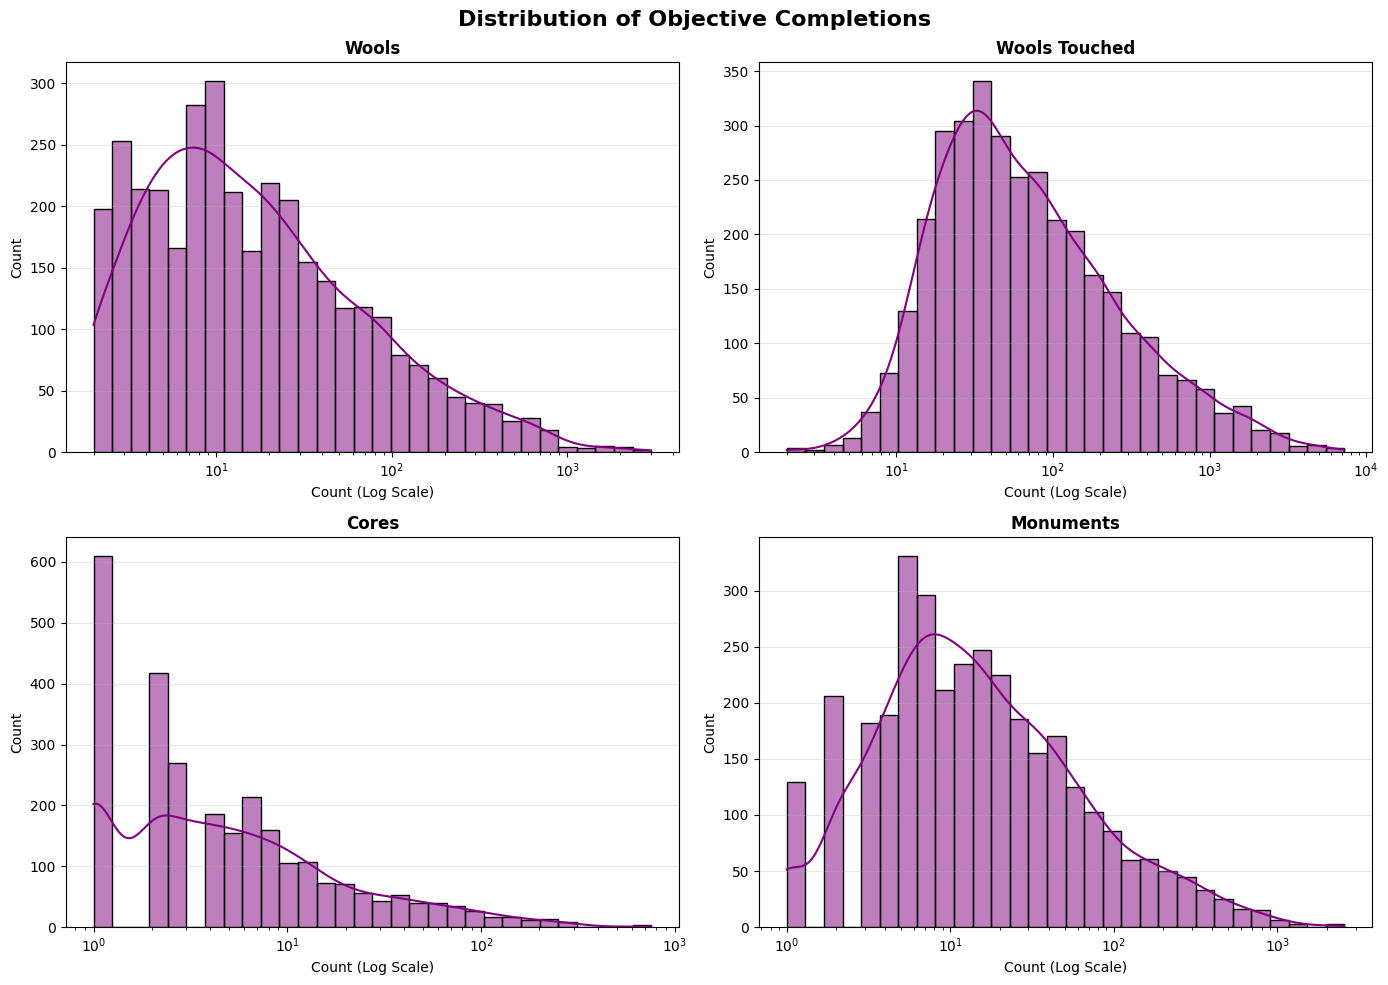

In [4]:
# Distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution of Objective Completions', fontsize=16, fontweight='bold')

for i, col in enumerate(obj_cols):
    ax = axes[i//2, i%2]
    # Log scale strictly for visualization of skewed data
    data = df[col][df[col] > 0]  # Filter zeros for log plot
    sns.histplot(data, bins=30, kde=True, ax=ax, color='purple', log_scale=True)
    ax.set_title(col.replace('_objectives', '').replace('_', ' ').title(), fontweight='bold')
    ax.set_xlabel('Count (Log Scale)')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'objectives_distribution.png', dpi=300)
plt.show()

## 3. Correlation Matrix: PvP vs Objectives ⚔️ vs 🚩
Do killers capture objectives? Or are they two different player types?

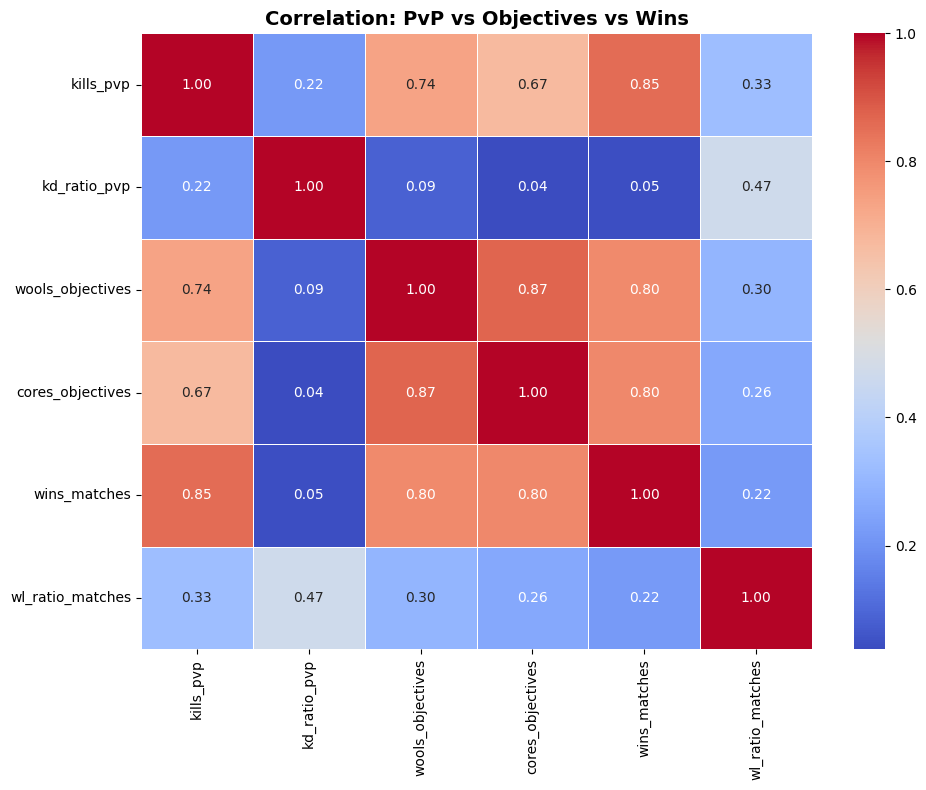

In [5]:
# Select key features from each category
corr_cols = [
    'kills_pvp', 'kd_ratio_pvp',  # PVP
    'wools_objectives', 'cores_objectives', # OBJECTIVES
    'wins_matches', 'wl_ratio_matches' # MATCHES
]

# We need to create the KD ratio column first if it doesn't exist (it doesn't in raw)
df['kd_ratio_pvp'] = df['kills_pvp'] / df['deaths_pvp'].replace(0, 1)

corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation: PvP vs Objectives vs Wins', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'pvp_vs_objectives_correlation.png', dpi=300)
plt.show()

## 4. The "Universal Soldier" Score 🎖️
We'll create a composite score to rank players who are good at EVERYTHING.

**Score Formula:** (Normalized Kills) + (Normalized Wins) + (Normalized Objectives)


In [6]:
# Normalize key metrics (Min-Max Scaling)
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

df['norm_kills'] = normalize(df['kills_pvp'])
df['norm_wins'] = normalize(df['wins_matches'])
df['norm_objs'] = normalize(df['wools_objectives'] + df['cores_objectives'] + df['monuments_objectives'])

# Calculate Composite Score
df['universal_score'] = (df['norm_kills'] * 0.4) + (df['norm_objs'] * 0.4) + (df['norm_wins'] * 0.2)

# Top 10 Universal Soldiers
top_soldiers = df.nlargest(10, 'universal_score')

print("TOP 10 UNIVERSAL SOLDIERS (Balanced Performance)")
print("="*80)
cols_to_show = ['player_id', 'universal_score', 'kills_pvp', 'wools_objectives', 'wins_matches']
print(top_soldiers[cols_to_show].to_string(index=False))

TOP 10 UNIVERSAL SOLDIERS (Balanced Performance)
          player_id  universal_score  kills_pvp  wools_objectives  wins_matches
player_c82cbd8215d7         0.895681   133982.0            2770.0        9953.0
player_64f3fc9bf409         0.836598   105979.0            3005.0        9272.0
player_166e579b149f         0.712566   153854.0            1288.0        8879.0
player_26d584629d48         0.686879   161437.0            1200.0        7914.0
player_cafecb0f80e7         0.634322    71716.0            1966.0        9978.0
player_ceee959e9253         0.614633   106063.0            2263.0        7280.0
player_910764e5a178         0.610470    88262.0            1739.0       10138.0
player_7544568392f2         0.540382   101617.0             935.0        7384.0
player_6a4be3fc5335         0.509132    70870.0            1560.0        6633.0
player_8cbc07752f34         0.489765   106417.0             622.0        7068.0


C:\Users\ofurn\AppData\Local\Temp\ipykernel_6780\3277473487.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_soldiers, x='universal_score', y='player_id', palette='magma')


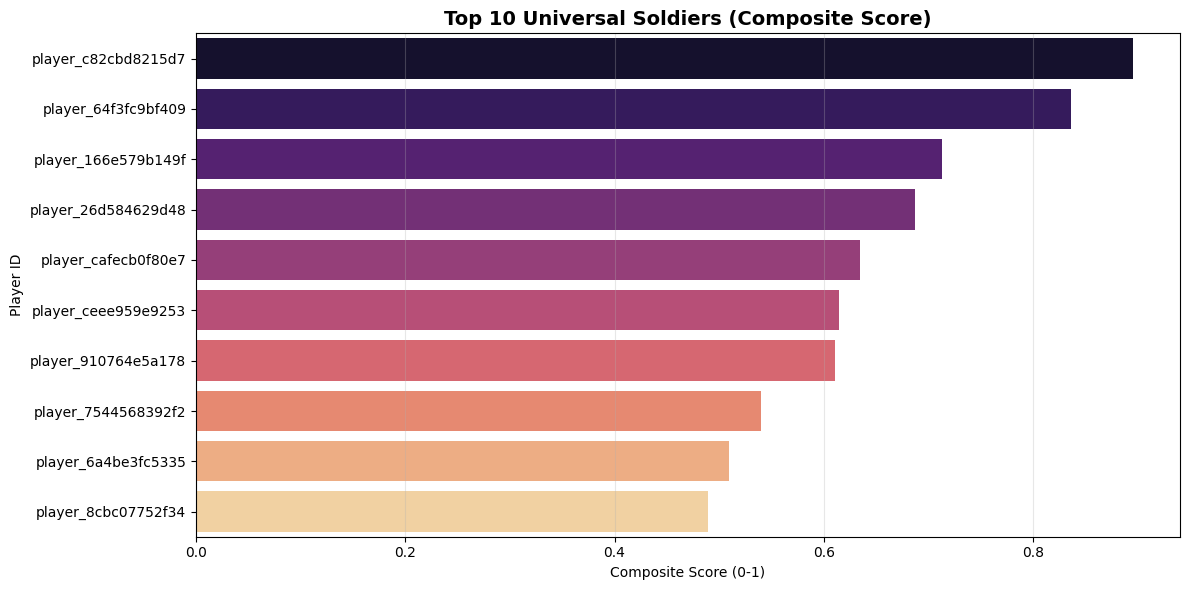

In [7]:
# Plot Top Soldiers
plt.figure(figsize=(12, 6))
sns.barplot(data=top_soldiers, x='universal_score', y='player_id', palette='magma')
plt.title('Top 10 Universal Soldiers (Composite Score)', fontsize=14, fontweight='bold')
plt.xlabel('Composite Score (0-1)')
plt.ylabel('Player ID')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'top_universal_soldiers.png', dpi=300)
plt.show()

## 5. Player Archetypes 🧬
Let's visualize the trade-off. Are you a Slayer or a Capper?

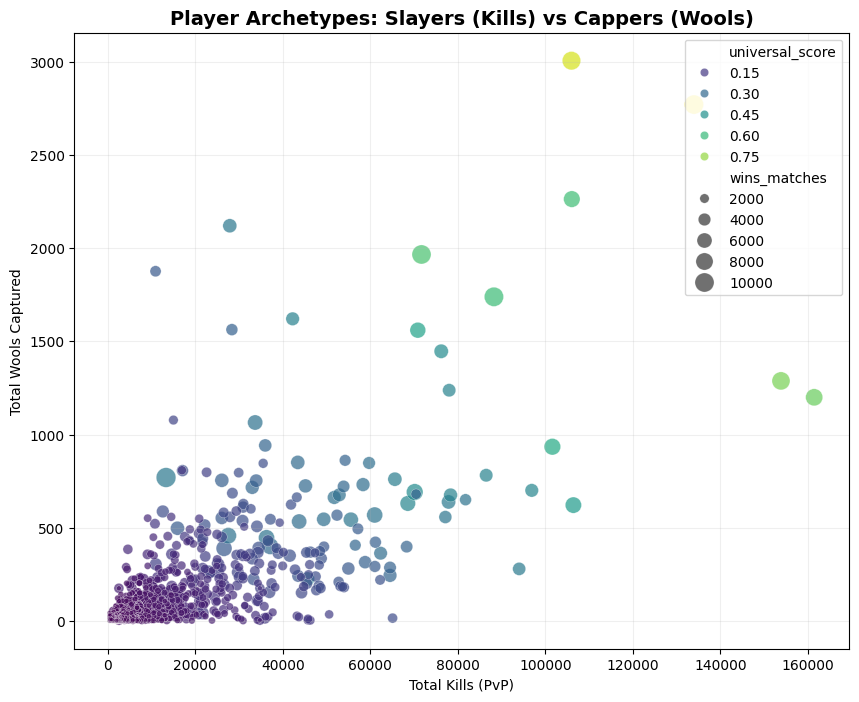

In [8]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='kills_pvp', y='wools_objectives', 
                hue='universal_score', palette='viridis', alpha=0.7, size='wins_matches', sizes=(10, 200))

plt.title('Player Archetypes: Slayers (Kills) vs Cappers (Wools)', fontsize=14, fontweight='bold')
plt.xlabel('Total Kills (PvP)')
plt.ylabel('Total Wools Captured')
plt.grid(True, alpha=0.2)

# Annotate top player
top_player = df.iloc[0]
# plt.text(top_player['kills_pvp'], top_player['wools_objectives'], 'Top #1', fontsize=9)

plt.savefig(PLOTS_DIR / 'archetypes_scatter.png', dpi=300)
plt.show()

In [9]:
print("\nAnalysis Complete!")
print(f"Plots saved to {PLOTS_DIR}")


Analysis Complete!
Plots saved to ..\plots
